In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

#logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph with navigation information

In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.4042418779,0],
    [0.79950060287,0], 
    [1.10492779947,0],
    [1.25764139777,0],
    [1.27560770345,0],
    [1.527135983,0],
    [1.69781588699,0], 
    [2.03019254211,0],
    [2.16493983473,0],
    [2.34460289155,0],
    [3.0093562018,0],
    [3.27885078704,0], 
    [3.36868231545,0],
    [4.06038508422,0],
    [4.06936823706,0], 
    [4.4915764206,0],
    [4.54547533765,0],
    [4.68022263026,0], 
    [5.04853189675,0],
    [5.2102286479,0],
    [5.68633574848,0],
    [6.1354933906,0],
    [6.5846510326,0], 
] 


# for each edge (between above coordinates) specify the depth (m)
depths = [
            7.5, 4.18, 4.18, 7.83,7.83, 
            7.5, 6.5, 10.6, 6.45, 8.04,
            8.04, 5.65, 8.87, 8.87, 4.93,
            4.93, 7.7,7.7, 9.8, 5.45, 5.45,5.45, 5.45
         ] # [m]

current_speeds = [
                    -2.24* 0.2777, -3.4* 0.2777, -4.93* 0.2777, -2.59* 0.2777, -2.59* 0.2777,
                    -3.26* 0.2777, -3.85* 0.2777, -1.87* 0.2777, -1.08* 0.2777, -2.83* 0.2777, 
                    -2.83* 0.2777, -4.99* 0.2777,  -2.89* 0.2777,  -2.89* 0.2777, -6.4* 0.2777,
                    -6.4* 0.2777, -3.42* 0.2777, -3.42* 0.2777, -1.64* 0.2777, -4.1* 0.2777, -4.1* 0.2777,-4.1* 0.2777, -4.1* 0.2777
                ]  # [m/s]

V_g_profile_up = [
                    3.33, 3.33, 3.33, 3.33, 3.33,   
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33,
                    3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33, 3.33
                ] # [m/s] for upstream, 3.33 m/s = 12 km/h

V_g_profile_down = [
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 4.44, 4.44, 
                     4.44, 4.44, 4.44, 3.33, 4.44, 4.44, 4.44, 4.44
                    ] # [m/s] for downstream, 4.44 m/s = 16 km/h


# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {
        "GeneralDepth": depths[index],
        "CurrentSpeed": current_speeds[index],
        "VesselSpeedToGroundProfile_upstream": V_g_profile_up[index],
        "VesselSpeedToGroundProfile_downstream": V_g_profile_down[index]
    })

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

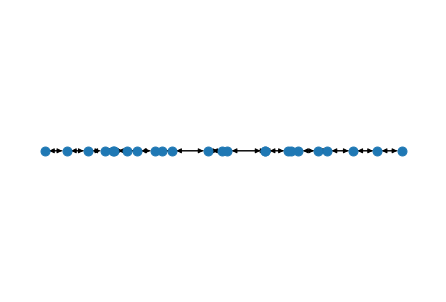

In [4]:
# show graph
nx.draw(FG, positions, node_size=80)

plt.show()

### Define the path 7 on the graph for energy use simulation

In [5]:
path_down_7_Regensburg2Budapest = nx.dijkstra_path(FG, nodes[0].name, nodes[23].name)

### Create vessel sailing on path 7 - add VesselProperties and ConsumesEnergy mixins

In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

vessels sailing on path 7 include 17 vessel types sailing downstream loaded and ballast

In [7]:
# Create a dict with all important settings

data_vessel_MCV135_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [8]:
# Create a dict with all important settings

data_vessel_MCV135_down_ballast = {
    "env": None,
    "name": 'MCV135_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 135,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1800,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [9]:
# Create a dict with all important settings

data_vessel_MCV110_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [10]:
# Create a dict with all important settings

data_vessel_MCV110_down_ballast = {
    "env": None,
    "name": 'MCV110_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [11]:
# Create a dict with all important settings

data_vessel_MCV110_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV110_1B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [12]:
# Create a dict with all important settings

data_vessel_MCV110_1B_down_ballast = {
    "env": None,
    "name": 'MCV110_1B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [13]:
# Create a dict with all important settings

data_vessel_MCV105_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV105_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [14]:
# Create a dict with all important settings

data_vessel_MCV105_down_ballast = {
    "env": None,
    "name": 'MCV105_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 105,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 950,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [15]:
# Create a dict with all important settings

data_vessel_MCV95_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV95_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [16]:
# Create a dict with all important settings

data_vessel_MCV95_down_ballast = {
    "env": None,
    "name": 'MCV95_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11,
    "L": 95,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1300,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [17]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_9_5_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [18]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_down_ballast = {
    "env": None,
    "name": 'MCV85_9_5_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [19]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV135_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 20,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [20]:
# Create a dict with all important settings

data_vessel_MCV85_9_5_1B_down_ballast = {
    "env": None,
    "name": 'MCV135_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 20,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [21]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV85_8_2_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [22]:
# Create a dict with all important settings

data_vessel_MCV85_8_2_down_ballast = {
    "env": None,
    "name": 'MCV85_8_2_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [23]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_down_loaded_MHWL = {
    "env": None,
    "name": 'MCV80_8_2_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [24]:
# Create a dict with all important settings

data_vessel_MCV80_8_2_down_ballast = {
    "env": None,
    "name": 'MCV80_8_2_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 8.2,
    "L": 80,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 600,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [25]:
# Create a dict with all important settings

data_vessel_MTV110_down_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [26]:
# Create a dict with all important settings

data_vessel_MTV110_down_ballast = {
    "env": None,
    "name": 'MTV110_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [27]:
# Create a dict with all important settings

data_vessel_MTV110_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'MTV110_1B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [28]:
# Create a dict with all important settings

data_vessel_MTV110_1B_down_ballast = {
    "env": None,
    "name": 'MTV110_1B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 110,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1150,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [29]:
# Create a dict with all important settings

data_vessel_MTV85_down_loaded_MHWL = {
    "env": None,
    "name": 'MTV85_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 2,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [30]:
# Create a dict with all important settings

data_vessel_MTV85_down_ballast = {
    "env": None,
    "name": 'MTV85_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 9.5,
    "L": 85,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 750,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 1,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [31]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_1B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [32]:
# Create a dict with all important settings

data_vessel_PUSH23_1B_down_ballast = {
    "env": None,
    "name": 'PUSH23_1B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 99.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [33]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH23_2B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 99.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [34]:
# Create a dict with all important settings

data_vessel_PUSH23_2B_down_ballast = {
    "env": None,
    "name": 'PUSH23_2B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 99.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1000,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [35]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_2B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 111.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [36]:
# Create a dict with all important settings

data_vessel_PUSH35_2B_down_ballast = {
    "env": None,
    "name": 'PUSH35_2B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 111.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1700,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [37]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH35_4B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [38]:
# Create a dict with all important settings

data_vessel_PUSH35_4B_down_ballast = {
    "env": None,
    "name": 'PUSH35_4B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 188,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2500,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [39]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_down_loaded_MHWL = {
    "env": None,
    "name": 'PUSH57_2B_down_loaded_MHWL',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 22.9,
    "L": 133.5,
    "T": 2.1,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed":1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



In [40]:
# Create a dict with all important settings

data_vessel_PUSH57_2B_down_ballast = {
    "env": None,
    "name": 'PUSH57_2B_down_ballast',
    "route": None,
    "geometry": None,
    "v": None,  # m/s
    "V_g_ave":3.53,
    "use_V_g_profile":True,
    "type": None,
    "B": 11.45,
    "L": 133.5,
    "T": 1.7,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": False, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Dry_DH", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 1470,   
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "sailing_on_power": False,
    "sailing_upstream":False,
    "wind_influence": False,
    "P_hotel_perc": 0.08,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 2.0 ,
    "C_B":0.85, 
    "C_year": 1980, # the engine construction year is only used for diesel use and emissions quantification
}             



### Define simulation

define basic simulation for vessel moving and consuming energy

In [41]:
def run_simulation(path,**data_vessel):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    # vessel.V_g_ave = V_g_ave
    # vessel.sailing_upstream = sailing_upstream
    # vessel.P_tot_given = P_tot_given
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

define specific vessel simulation with vessel type and number of trips

In [42]:
def get_energy(nr_trips, path,**data_vessel):
    vessel = run_simulation(path,**data_vessel)
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel=vessel)
    energycalculation.calculate_energy_consumption()
    
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    # selected = ['edge_start','edge_stop','distance','total_energy','total_H2_350bar_PEMFC_mass','total_H2_350bar_PEMFC_40ft_containers']
    # df_energy = df[selected]
    # df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    # df_energy['total_trips_H2_350bar_PEMFC_mass_ton'] = df_energy['total_H2_350bar_PEMFC_mass']*nr_trips/1000000
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'] = df_energy['total_H2_350bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    # df_energy['total_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_350bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    selected = ['distance','total_H2_500bar_PEMFC_40ft_containers']
    df_energy = df[selected]
    df_energy['distance_km_cum']=df_energy['distance'].cumsum()/1000
    # df_energy['total_trips_energy'] = df_energy['total_energy']*nr_trips
    # df_energy['total_trips_H2_350bar_PEMFC_mass_ton'] = df_energy['total_H2_350bar_PEMFC_mass']*nr_trips/1000000
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'] = df_energy['total_H2_350bar_PEMFC_40ft_containers']*nr_trips
    # df_energy['energy_consumption_kWh_cum'] = df_energy['total_energy'].cumsum()
    # df_energy['total_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_H2_350bar_PEMFC_mass'].cumsum()/1000000
    df_energy['total_H2_500bar_PEMFC_40ft_containers_cum'] = df_energy['total_H2_500bar_PEMFC_40ft_containers'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_mass_cum_ton'] = df_energy['total_trips_H2_350bar_PEMFC_mass_ton'].cumsum()
    # df_energy['total_trips_H2_350bar_PEMFC_40ft_containers_cum'] = df_energy['total_trips_H2_350bar_PEMFC_40ft_containers'].cumsum()
    
    return df_energy

In [43]:
energy_MCV135_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV135_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV135_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.072793,45.0,0.072793
1,43999.999995,0.061385,89.0,0.134178
2,34000.000000,0.044155,123.0,0.178333
3,17000.000000,0.025258,140.0,0.203591
4,2000.000000,0.002971,142.0,0.206563
5,28000.000000,0.035273,170.0,0.241835
6,19000.000001,0.022058,189.0,0.263893
7,37000.000000,0.063441,226.0,0.327333
8,15000.000000,0.036271,241.0,0.363604
9,20000.000000,0.027769,261.0,0.391373


In [44]:
energy_MCV135_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV135_down_ballast)
# pd.options.display.max_columns = None
energy_MCV135_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.096967,45.0,0.096967
1,43999.999995,0.071753,89.0,0.168720
2,34000.000000,0.043653,123.0,0.212373
3,17000.000000,0.032785,140.0,0.245158
4,2000.000000,0.003857,142.0,0.249015
5,28000.000000,0.045031,170.0,0.294046
6,19000.000001,0.026929,189.0,0.320975
7,37000.000000,0.087669,226.0,0.408645
8,15000.000000,0.050128,241.0,0.458773
9,20000.000000,0.036013,261.0,0.494786


In [45]:
energy_MCV110_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.060098,45.0,0.060098
1,43999.999995,0.050727,89.0,0.110825
2,34000.000000,0.025850,123.0,0.136675
3,17000.000000,0.020690,140.0,0.157364
4,2000.000000,0.002434,142.0,0.159799
5,28000.000000,0.029087,170.0,0.188886
6,19000.000001,0.018327,189.0,0.207212
7,37000.000000,0.052661,226.0,0.259873
8,15000.000000,0.030039,241.0,0.289913
9,20000.000000,0.022794,261.0,0.312706


In [46]:
energy_MCV110_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_down_ballast)
# pd.options.display.max_columns = None
energy_MCV110_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.062926,45.0,0.062926
1,43999.999995,0.049097,89.0,0.112023
2,34000.000000,0.025860,123.0,0.137883
3,17000.000000,0.021394,140.0,0.159277
4,2000.000000,0.002517,142.0,0.161794
5,28000.000000,0.029618,170.0,0.191412
6,19000.000001,0.018038,189.0,0.209450
7,37000.000000,0.056317,226.0,0.265767
8,15000.000000,0.032020,241.0,0.297787
9,20000.000000,0.023471,261.0,0.321258


In [47]:
energy_MCV110_1B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV110_1B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.113969,45.0,0.113969
1,43999.999995,0.100401,89.0,0.214371
2,34000.000000,0.050143,123.0,0.264514
3,17000.000000,0.039857,140.0,0.304370
4,2000.000000,0.004689,142.0,0.309059
5,28000.000000,0.055912,170.0,0.364972
6,19000.000001,0.034991,189.0,0.399963
7,37000.000000,0.098415,226.0,0.498378
8,15000.000000,0.057643,241.0,0.556020
9,20000.000000,0.044029,261.0,0.600049


In [48]:
energy_MCV110_1B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV110_1B_down_ballast)
# pd.options.display.max_columns = None
energy_MCV110_1B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.110150,45.0,0.110150
1,43999.999995,0.093153,89.0,0.203304
2,34000.000000,0.045731,123.0,0.249035
3,17000.000000,0.038295,140.0,0.287330
4,2000.000000,0.004505,142.0,0.291835
5,28000.000000,0.052654,170.0,0.344489
6,19000.000001,0.032313,189.0,0.376802
7,37000.000000,0.096064,226.0,0.472866
8,15000.000000,0.054998,241.0,0.527864
9,20000.000000,0.042277,261.0,0.570141


In [49]:
energy_MCV105_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV105_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV105_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.058970,45.0,0.058970
1,43999.999995,0.049592,89.0,0.108563
2,34000.000000,0.024979,123.0,0.133541
3,17000.000000,0.020404,140.0,0.153945
4,2000.000000,0.002400,142.0,0.156346
5,28000.000000,0.028054,170.0,0.184400
6,19000.000001,0.017689,189.0,0.202089
7,37000.000000,0.051205,226.0,0.253294
8,15000.000000,0.029223,241.0,0.282517
9,20000.000000,0.022243,261.0,0.304759


In [50]:
energy_MCV105_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV105_down_ballast)
# pd.options.display.max_columns = None
energy_MCV105_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.059979,45.0,0.059979
1,43999.999995,0.046926,89.0,0.106905
2,34000.000000,0.023240,123.0,0.130145
3,17000.000000,0.020610,140.0,0.150755
4,2000.000000,0.002425,142.0,0.153180
5,28000.000000,0.027993,170.0,0.181173
6,19000.000001,0.017100,189.0,0.198274
7,37000.000000,0.052950,226.0,0.251224
8,15000.000000,0.030023,241.0,0.281247
9,20000.000000,0.022443,261.0,0.303690


In [51]:
energy_MCV95_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV95_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV95_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.050823,45.0,0.050823
1,43999.999995,0.043214,89.0,0.094037
2,34000.000000,0.031894,123.0,0.125931
3,17000.000000,0.017719,140.0,0.143650
4,2000.000000,0.002085,142.0,0.145735
5,28000.000000,0.024925,170.0,0.170660
6,19000.000001,0.015974,189.0,0.186634
7,37000.000000,0.044313,226.0,0.230947
8,15000.000000,0.024980,241.0,0.255927
9,20000.000000,0.019523,261.0,0.275449


In [52]:
energy_MCV95_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV95_down_ballast)
# pd.options.display.max_columns = None
energy_MCV95_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.050607,45.0,0.050607
1,43999.999995,0.041003,89.0,0.091610
2,34000.000000,0.031923,123.0,0.123534
3,17000.000000,0.017519,140.0,0.141053
4,2000.000000,0.002061,142.0,0.143114
5,28000.000000,0.024481,170.0,0.167594
6,19000.000001,0.016582,189.0,0.184176
7,37000.000000,0.044548,226.0,0.228724
8,15000.000000,0.024779,241.0,0.253503
9,20000.000000,0.019306,261.0,0.272809


In [53]:
energy_MCV85_9_5_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.042531,45.0,0.042531
1,43999.999995,0.035286,89.0,0.077816
2,34000.000000,0.018021,123.0,0.095838
3,17000.000000,0.014647,140.0,0.110485
4,2000.000000,0.001723,142.0,0.112208
5,28000.000000,0.020422,170.0,0.132630
6,19000.000001,0.012870,189.0,0.145500
7,37000.000000,0.037338,226.0,0.182838
8,15000.000000,0.021251,241.0,0.204089
9,20000.000000,0.015992,261.0,0.220081


In [54]:
energy_MCV85_9_5_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_down_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.041365,45.0,0.041365
1,43999.999995,0.033098,89.0,0.074464
2,34000.000000,0.016805,123.0,0.091269
3,17000.000000,0.014156,140.0,0.105425
4,2000.000000,0.001665,142.0,0.107090
5,28000.000000,0.019741,170.0,0.126832
6,19000.000001,0.012145,189.0,0.138977
7,37000.000000,0.036719,226.0,0.175696
8,15000.000000,0.020590,241.0,0.196286
9,20000.000000,0.015536,261.0,0.211822


In [55]:
energy_MCV85_9_5_1B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.087025,45.0,0.087025
1,43999.999995,0.073124,89.0,0.160149
2,34000.000000,0.036717,123.0,0.196866
3,17000.000000,0.029405,140.0,0.226271
4,2000.000000,0.003459,142.0,0.229731
5,28000.000000,0.041682,170.0,0.271413
6,19000.000001,0.026545,189.0,0.297958
7,37000.000000,0.075664,226.0,0.373622
8,15000.000000,0.043526,241.0,0.417149
9,20000.000000,0.032406,261.0,0.449555


In [56]:
energy_MCV85_9_5_1B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_9_5_1B_down_ballast)
# pd.options.display.max_columns = None
energy_MCV85_9_5_1B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.081533,45.0,0.081533
1,43999.999995,0.068339,89.0,0.149872
2,34000.000000,0.034388,123.0,0.184260
3,17000.000000,0.027968,140.0,0.212227
4,2000.000000,0.003290,142.0,0.215518
5,28000.000000,0.039674,170.0,0.255191
6,19000.000001,0.024389,189.0,0.279580
7,37000.000000,0.072619,226.0,0.352199
8,15000.000000,0.041240,241.0,0.393439
9,20000.000000,0.030936,261.0,0.424374


In [57]:
energy_MCV85_8_2_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_8_2_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV85_8_2_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.037916,45.0,0.037916
1,43999.999995,0.031778,89.0,0.069694
2,34000.000000,0.015968,123.0,0.085661
3,17000.000000,0.013193,140.0,0.098854
4,2000.000000,0.001552,142.0,0.100406
5,28000.000000,0.018132,170.0,0.118538
6,19000.000001,0.011418,189.0,0.129956
7,37000.000000,0.033003,226.0,0.162960
8,15000.000000,0.018715,241.0,0.181675
9,20000.000000,0.014394,261.0,0.196069


In [58]:
energy_MCV85_8_2_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV85_8_2_down_ballast)
# pd.options.display.max_columns = None
energy_MCV85_8_2_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.036875,45.0,0.036875
1,43999.999995,0.029445,89.0,0.066320
2,34000.000000,0.014862,123.0,0.081182
3,17000.000000,0.012691,140.0,0.093874
4,2000.000000,0.001493,142.0,0.095367
5,28000.000000,0.017456,170.0,0.112823
6,19000.000001,0.010752,189.0,0.123575
7,37000.000000,0.032291,226.0,0.155866
8,15000.000000,0.018005,241.0,0.173871
9,20000.000000,0.013864,261.0,0.187735


In [59]:
energy_MCV80_8_2_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV80_8_2_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MCV80_8_2_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.036427,45.0,0.036427
1,43999.999995,0.030267,89.0,0.066694
2,34000.000000,0.015312,123.0,0.082006
3,17000.000000,0.012593,140.0,0.094599
4,2000.000000,0.001482,142.0,0.096081
5,28000.000000,0.017393,170.0,0.113474
6,19000.000001,0.010961,189.0,0.124436
7,37000.000000,0.031760,226.0,0.156196
8,15000.000000,0.018036,241.0,0.174231
9,20000.000000,0.013741,261.0,0.187972


In [60]:
energy_MCV80_8_2_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MCV80_8_2_down_ballast)
# pd.options.display.max_columns = None
energy_MCV80_8_2_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.035133,45.0,0.035133
1,43999.999995,0.027958,89.0,0.063091
2,34000.000000,0.014220,123.0,0.077311
3,17000.000000,0.012036,140.0,0.089347
4,2000.000000,0.001416,142.0,0.090764
5,28000.000000,0.016677,170.0,0.107441
6,19000.000001,0.010274,189.0,0.117715
7,37000.000000,0.030880,226.0,0.148595
8,15000.000000,0.017244,241.0,0.165839
9,20000.000000,0.013150,261.0,0.178988


In [61]:
energy_MTV110_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.060098,45.0,0.060098
1,43999.999995,0.050727,89.0,0.110825
2,34000.000000,0.025850,123.0,0.136675
3,17000.000000,0.020690,140.0,0.157364
4,2000.000000,0.002434,142.0,0.159799
5,28000.000000,0.029087,170.0,0.188886
6,19000.000001,0.018327,189.0,0.207212
7,37000.000000,0.052661,226.0,0.259873
8,15000.000000,0.030039,241.0,0.289913
9,20000.000000,0.022794,261.0,0.312706


In [62]:
energy_MTV110_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_down_ballast)
# pd.options.display.max_columns = None
energy_MTV110_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.062926,45.0,0.062926
1,43999.999995,0.049097,89.0,0.112023
2,34000.000000,0.025860,123.0,0.137883
3,17000.000000,0.021394,140.0,0.159277
4,2000.000000,0.002517,142.0,0.161794
5,28000.000000,0.029618,170.0,0.191412
6,19000.000001,0.018038,189.0,0.209450
7,37000.000000,0.056317,226.0,0.265767
8,15000.000000,0.032020,241.0,0.297787
9,20000.000000,0.023471,261.0,0.321258


In [63]:
energy_MTV110_1B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV110_1B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.113969,45.0,0.113969
1,43999.999995,0.100401,89.0,0.214371
2,34000.000000,0.050143,123.0,0.264514
3,17000.000000,0.039857,140.0,0.304370
4,2000.000000,0.004689,142.0,0.309059
5,28000.000000,0.055912,170.0,0.364972
6,19000.000001,0.034991,189.0,0.399963
7,37000.000000,0.098415,226.0,0.498378
8,15000.000000,0.057643,241.0,0.556020
9,20000.000000,0.044029,261.0,0.600049


In [64]:
energy_MTV110_1B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV110_1B_down_ballast)
# pd.options.display.max_columns = None
energy_MTV110_1B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.110150,45.0,0.110150
1,43999.999995,0.093153,89.0,0.203304
2,34000.000000,0.045731,123.0,0.249035
3,17000.000000,0.038295,140.0,0.287330
4,2000.000000,0.004505,142.0,0.291835
5,28000.000000,0.052654,170.0,0.344489
6,19000.000001,0.032313,189.0,0.376802
7,37000.000000,0.096064,226.0,0.472866
8,15000.000000,0.054998,241.0,0.527864
9,20000.000000,0.042277,261.0,0.570141


In [65]:
energy_MTV85_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV85_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_MTV85_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.042531,45.0,0.042531
1,43999.999995,0.035286,89.0,0.077816
2,34000.000000,0.018021,123.0,0.095838
3,17000.000000,0.014647,140.0,0.110485
4,2000.000000,0.001723,142.0,0.112208
5,28000.000000,0.020422,170.0,0.132630
6,19000.000001,0.012870,189.0,0.145500
7,37000.000000,0.037338,226.0,0.182838
8,15000.000000,0.021251,241.0,0.204089
9,20000.000000,0.015992,261.0,0.220081


In [66]:
energy_MTV85_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_MTV85_down_ballast)
# pd.options.display.max_columns = None
energy_MTV85_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.041365,45.0,0.041365
1,43999.999995,0.033098,89.0,0.074464
2,34000.000000,0.016805,123.0,0.091269
3,17000.000000,0.014156,140.0,0.105425
4,2000.000000,0.001665,142.0,0.107090
5,28000.000000,0.019741,170.0,0.126832
6,19000.000001,0.012145,189.0,0.138977
7,37000.000000,0.036719,226.0,0.175696
8,15000.000000,0.020590,241.0,0.196286
9,20000.000000,0.015536,261.0,0.211822


In [67]:
energy_PUSH23_1B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_1B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_1B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.056135,45.0,0.056135
1,43999.999995,0.046947,89.0,0.103083
2,34000.000000,0.024032,123.0,0.127115
3,17000.000000,0.019301,140.0,0.146416
4,2000.000000,0.002271,142.0,0.148687
5,28000.000000,0.026957,170.0,0.175644
6,19000.000001,0.017008,189.0,0.192652
7,37000.000000,0.049142,226.0,0.241794
8,15000.000000,0.028034,241.0,0.269828
9,20000.000000,0.021105,261.0,0.290933


In [68]:
energy_PUSH23_1B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_1B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_1B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.055955,45.0,0.055955
1,43999.999995,0.044205,89.0,0.100159
2,34000.000000,0.022219,123.0,0.122378
3,17000.000000,0.019074,140.0,0.141452
4,2000.000000,0.002244,142.0,0.143696
5,28000.000000,0.026438,170.0,0.170135
6,19000.000001,0.016195,189.0,0.186330
7,37000.000000,0.049743,226.0,0.236073
8,15000.000000,0.028154,241.0,0.264227
9,20000.000000,0.020877,261.0,0.285104


In [69]:
energy_PUSH23_2B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_2B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH23_2B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.108334,45.0,0.108334
1,43999.999995,0.093920,89.0,0.202255
2,34000.000000,0.047209,123.0,0.249464
3,17000.000000,0.037316,140.0,0.286779
4,2000.000000,0.004390,142.0,0.291170
5,28000.000000,0.053068,170.0,0.344238
6,19000.000001,0.033571,189.0,0.377809
7,37000.000000,0.095141,226.0,0.472950
8,15000.000000,0.055094,241.0,0.528044
9,20000.000000,0.041250,261.0,0.569294


In [70]:
energy_PUSH23_2B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH23_2B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH23_2B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.101155,45.0,0.101155
1,43999.999995,0.086583,89.0,0.187738
2,34000.000000,0.043301,123.0,0.231038
3,17000.000000,0.035290,140.0,0.266329
4,2000.000000,0.004152,142.0,0.270481
5,28000.000000,0.049668,170.0,0.320149
6,19000.000001,0.030273,189.0,0.350421
7,37000.000000,0.089265,226.0,0.439686
8,15000.000000,0.051199,241.0,0.490885
9,20000.000000,0.039019,261.0,0.529904


In [71]:
energy_PUSH35_2B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_2B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_2B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.110755,45.0,0.110755
1,43999.999995,0.097332,89.0,0.208087
2,34000.000000,0.049335,123.0,0.257422
3,17000.000000,0.038725,140.0,0.296147
4,2000.000000,0.004556,142.0,0.300702
5,28000.000000,0.053750,170.0,0.354452
6,19000.000001,0.033991,189.0,0.388443
7,37000.000000,0.095319,226.0,0.483762
8,15000.000000,0.053908,241.0,0.537670
9,20000.000000,0.042416,261.0,0.580086


In [72]:
energy_PUSH35_2B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_2B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_2B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.107425,45.0,0.107425
1,43999.999995,0.089316,89.0,0.196741
2,34000.000000,0.045604,123.0,0.242345
3,17000.000000,0.037179,140.0,0.279524
4,2000.000000,0.004374,142.0,0.283898
5,28000.000000,0.051078,170.0,0.334976
6,19000.000001,0.031707,189.0,0.366683
7,37000.000000,0.093777,226.0,0.460460
8,15000.000000,0.052822,241.0,0.513282
9,20000.000000,0.040597,261.0,0.553880


In [73]:
energy_PUSH35_4B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_4B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH35_4B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.312362,45.0,0.312362
1,43999.999995,0.220452,89.0,0.532813
2,34000.000000,0.086719,123.0,0.619533
3,17000.000000,0.102679,140.0,0.722212
4,2000.000000,0.012080,142.0,0.734292
5,28000.000000,0.133591,170.0,0.867883
6,19000.000001,0.076340,189.0,0.944223
7,37000.000000,0.283104,226.0,1.227327
8,15000.000000,0.189159,241.0,1.416486
9,20000.000000,0.109191,261.0,1.525677


In [74]:
energy_PUSH35_4B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH35_4B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH35_4B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.601240,45.0,0.601240
1,43999.999995,0.587879,89.0,1.189120
2,34000.000000,0.454270,123.0,1.643390
3,17000.000000,0.227135,140.0,1.870525
4,2000.000000,0.026722,142.0,1.897247
5,28000.000000,0.374105,170.0,2.271352
6,19000.000001,0.253857,189.0,2.525209
7,37000.000000,0.494353,226.0,3.019562
8,15000.000000,0.200413,241.0,3.219976
9,20000.000000,0.267218,261.0,3.487194


In [75]:
energy_PUSH57_2B_down_loaded_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH57_2B_down_loaded_MHWL)
# pd.options.display.max_columns = None
energy_PUSH57_2B_down_loaded_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.132838,45.0,0.132838
1,43999.999995,0.115162,89.0,0.248000
2,34000.000000,0.056233,123.0,0.304232
3,17000.000000,0.046243,140.0,0.350475
4,2000.000000,0.005440,142.0,0.355915
5,28000.000000,0.062731,170.0,0.418646
6,19000.000001,0.039756,189.0,0.458402
7,37000.000000,0.114936,226.0,0.573339
8,15000.000000,0.066726,241.0,0.640065
9,20000.000000,0.050140,261.0,0.690204


In [76]:
energy_PUSH57_2B_down_ballast_MHWL_path_7 = get_energy(17,path_down_7_Regensburg2Budapest,**data_vessel_PUSH57_2B_down_ballast)
# pd.options.display.max_columns = None
energy_PUSH57_2B_down_ballast_MHWL_path_7

C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:21: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\manjiang\AppData\Local\Temp\ipykernel_10880\303162001.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,distance,total_H2_500bar_PEMFC_40ft_containers,distance_km_cum,total_H2_500bar_PEMFC_40ft_containers_cum
0,45000.000005,0.094910,45.0,0.094910
1,43999.999995,0.069503,89.0,0.164412
2,34000.000000,0.032228,123.0,0.196641
3,17000.000000,0.032501,140.0,0.229141
4,2000.000000,0.003824,142.0,0.232965
5,28000.000000,0.043464,170.0,0.276429
6,19000.000001,0.026015,189.0,0.302444
7,37000.000000,0.084839,226.0,0.387282
8,15000.000000,0.048381,241.0,0.435663
9,20000.000000,0.035302,261.0,0.470965
